# 1. Import & Setting

### 1-1) Parameter Setting

In [1]:
DEFAULT_ENCODING = "cp949"
STATION_DF_PATH = "data/analysis/station_df.csv"
USER_DF_PATH = "data/analysis/user_df.csv"
TOUR_STATION_CANDIDATE_DF_PATH = "data/analysis/tour_station_candidate_df.csv"

### 1-2) Path Setting

In [2]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

### 1-3) Import

In [4]:
import datetime
import numpy as np
import pandas as pd
import multiprocessing
from functools import partial
from multiprocessing import Pool

import bus.analyzer as anz

import os
import datetime
import requests
import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm
from pyarrow import csv
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
import xml.etree.ElementTree as elemTree
from multiprocessing import Pool

### 1-4) 한글 폰트 설정

In [5]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2) Library

### 2-1) Pandas Analysis Library

#### * 이용량 분석

In [6]:
"""
* function        : object에 대한 subject의 이용량을 계산하여 반환
* s_df(subject_df): 이용자 정보를 담는 테이블
* o_df(object_df) : 타켓 정보를 담는 테이블
* u_df(usage_df)  : subject의 object이용 정보를 담는 테이블
* s_id(subject_id): subject_df의 키 컬럼 명시
* o_id(object_id) : object_df의 키 컬럼 명시 
* column : 이용량을 나타내는 결과 컬럼 네임 명시

* 매개변수에 대한 const 설정 보장(수정 안함)
"""
def get_usage(s_df, o_df, u_df, column = "usage",
                                     s_id = "subject_id", o_id="object_id"):
    # 필요한 컬럼 추출 및 결측치 제거
    o_df = o_df.copy()[[o_id]].dropna()
    s_df = s_df.copy()[[s_id]].dropna()
    u_df = u_df.copy()[[s_id, o_id]].dropna()
    
    # 원하는 정보만 추출 - u_df에서 s_df에 존재하는 id와 연관된 데이터만 추출한다.
    u_df = pd.merge(u_df, s_df, on=s_id, how="inner")
    
    # 이용량 계산
    u_df = u_df.groupby(by=o_id).count().reset_index().rename(columns={s_id:column})
    
    # 전체 object에 대해 이용량 컬럼 생성
    o_df = pd.merge(o_df, u_df, on=o_id, how="outer").fillna(0)

    return o_df

### 2-2) Bus Analysis Library

#### * 정류장 이용량 분석

In [7]:
"""
* function: 이용자가 정류장에 승 하차를 몇번했는 지를 카운트 하여 원하는 컬럼명으로 생성
* orders  : 작업 내용 명세 리스트
            - form [order, order, ..., order]
            
* order   : 작업 내용 명세
            - form: = [user, behavior, column]
            
* user    : [ "total" | "tourist" | "remainder" ]
* behavior: [ "geton" | "getoff" ]
* column  : string
"""
def analyze_station_usage(station_df, user_df, usage_df, orders):
    
    # 관광객 여부가 판별되지 않은 경우에 대한 임시적 예외처리
    if "tourist" not in user_df.columns: 
        print("There is no column  'tourist'")
        print("create 'tourist' column that the value is False")
        user_df = user_df.copy()
        user_df["tourist"] = False
        
    # order에 대한 실직적인 데이터 저장___________________________________________________
    subject_dic = {"total": user_df, 
                   "tourist": user_df[user_df["tourist"] == True], 
                   "remainder":user_df[user_df["tourist"] == False]}
    
    usage_dic   = {"geton": usage_df.rename(columns={"geton_station_id":"station_id"}), 
                   "getoff":usage_df.rename(columns={"getoff_station_id":"station_id"})}
    
    # order수행___________________________________________________________________________
    for order in orders: 
        # get_usage()에 대한 파라미터 세팅________________________________________________
        user, behavior, column = order
        s_df = subject_dic[user]   # user에 따라 전체 이용자, 관광객 이용자, 나머지 이용자를 추출
        o_df = station_df          # 항상 station_df로 고정 
        u_df = usage_dic[behavior] # behavior에 따라 승차 또는 하차 데이터 컬럼을 station_id로 변경 for using get_usage()
        
        # get_usag() 수행 후 결과 반영____________________________________________________
        result_df = get_usage(s_df, o_df, u_df, column = column, s_id="user_id", o_id="station_id")
        if column in station_df.columns:
            del station_df[column]
        station_df[column] = result_df[column]
        
    return station_df

# 3. 정류장 & 이용자 추출 및 분석

### 3-1) 이용데이터 로딩

In [8]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

# 전체 데이터 로딩 (multi)
usage_df = anz.parallel_load_total_usage_df(input_path_list)

In [14]:
station_df = pd.read_csv(STATION_DF_PATH, encoding = DEFAULT_ENCODING)

In [15]:
user_df = pd.read_csv(USER_DF_PATH, encoding = DEFAULT_ENCODING)

### 3-2) 정류장 & 이용자 추출

#### 3-2-1) 전체 이용 정류장 추출

In [16]:
def create_station_df(usage_df):
    # 추출할 컬럼 리스트
    station_columns = ['station_id', 'station_name', 'station_longitude', 'station_latitude']
    
    # 승차, 하차 데이터 추출을 위한 컬럼 네임 변경 데이터 생성__________________________________________________
    geton_rename_dict = {}
    getoff_rename_dict = {}
    geton_station_columns = ['geton_station_id', 'geton_stataion_name', 'geton_station_longitude', 'geton_station_latitude']
    getoff_station_columns = ['getoff_station_id', 'getoff_station_name', 'getoff_station_longitude', 'getoff_station_latitude']
    for i, column in enumerate(station_columns):
        geton_rename_dict[geton_station_columns[i]] = column
        getoff_rename_dict[getoff_station_columns[i]] = column
    
    # 데이터 추출 (승차, 하차 개별)_____________________________________________________________________________
    geton_station_df = usage_df[geton_station_columns].drop_duplicates().rename(columns = geton_rename_dict).dropna()
    getoff_station_df = usage_df[getoff_station_columns].drop_duplicates().rename(columns = getoff_rename_dict).dropna()
    
    # 승차, 하차 데이터 병합____________________________________________________________________________________
    station_df = pd.concat([geton_station_df, getoff_station_df]).drop_duplicates()
    
    # 예외처리 - 하나의 id에 대하여 여러 경도, 위도 존재________________________________________________________
    id_count_df = pd.DataFrame(station_df['station_id'].value_counts()).reset_index().rename(columns = {'index':'station_id', 'station_id':'count'})
    exception_df = id_count_df[id_count_df['count'] >1]
    exception_id_list = list(exception_df['station_id'])
    for exception_id in exception_id_list:
        temp_df = station_df[station_df['station_id'] == exception_id]
        station_df = station_df[station_df['station_id'] != exception_id]
        station_df = pd.concat([station_df, temp_df.head(1)])
    
    station_df = station_df.sort_values(by="station_id")
    station_df.reset_index(inplace = True)
    del station_df["index"]
    return station_df

#정류장 추출
station_df = anz.create_station_df(usage_df)

#### 3-2-2) 전체 이용자 추출

In [21]:
def create_user_df(usage_df):    # 유저 목록 생성
    user_df = usage_df[["user_id"]].drop_duplicates()
    user_df.reset_index(inplace = True)
    del user_df["index"]
    return user_df

# 유저 목록 생성
user_df = create_user_df(usage_df)

### 3-3) 이용자 및 정류장 분석

#### 3-3-1) 정류장 주소 계산 및 컬럼 삽입

In [22]:
# 정류장 주소 추가 API 사용 함수
def get_address(loc_x, loc_y, mean_x = 126.531891, mean_y = 33.399409, 
                key = "E20F6493-C13D-3F6F-AC90-D5BB2F239901",
                url_form = "http://api.vworld.kr/req/address?service=address&request=getAddress&version=2.0&crs=epsg:4326&point={},{}&format=xml&type=both&zipcode=true&simple=false&key={}"):

    # 위도, 경도 반올림 for 빠른 예외처리를 위해
    loc_x = round(float(loc_x), 7)
    loc_y = round(float(loc_y), 7)
    
    url = url_form.format(loc_x, loc_y, key)
    response = requests.get(url)
    tree = elemTree.fromstring(response.text)
    
    try:
        #response(xml)로 부터 주소 데이터 추출
        address = tree.find("result").find("item[1]").find("text").text
    
    except: # 위도 경도가 바다 위에 있는 경우 API 결과의 주소 데이터가 비어있다.
#         print("현재 좌표: ",(loc_x, loc_y), "주소 없음")
        x_left = str(int(loc_x))
        y_left = str(int(loc_y))
        
        if mean_x < loc_x:
            x_right = str((int(loc_x*100000)-2)%100000)
        else:
            x_right = str((int(loc_x*100000)+2)%100000)
            
        if mean_y < loc_y:
            y_right = str((int(loc_y*100000)-2)%100000)
        else:
            y_right = str((int(loc_y*100000)+2)%100000)
            
        loc_x = float(x_left+"."+x_right)
        loc_y = float(y_left+"."+y_right)
        return get_address(loc_x, loc_y)
            
    return address

def set_station_address_column(df, longitude_column="station_longitude", latitude_columns = "station_latitude", result_column = "station_address"):
    df = pd.DataFrame.copy(df)
    
    if result_column in df.columns:# result_columns이 이미 존재한다면 제거
        del df[result_column]
        
    df[result_column] = ""
    for i in tqdm(df.index):
        df.loc[i, result_column] = get_address(float(df.loc[i, longitude_column]), float(df.loc[i, latitude_columns]))
    
    return df

station_df = set_station_address_column(station_df)

100%|██████████████████████████████████████████████████████████████████████████████| 3654/3654 [04:40<00:00, 13.03it/s]


#### 3-3-2) 정류장 별 이용량 계산 및 컬럼 삽입

In [23]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["total",   "geton",  "total_geton"],
          ["total",   "getoff", "total_getoff"]]

# 전체 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

There is no column  'tourist'
create 'tourist' column that the value is False


#### 3-3-3) 정류장 별 출입정류장(공항, 항만) 판단 및 컬럼 삽입

In [24]:
"""
* function: _object가 comparator_list의 임의의 요소와 관계가 있는지 판별
    - 관계: 비교자가 비교 대상의 부분 문자열이면 관계가 있다.
    
* target: 비교 대상
    - form: string
    
* comparators: 비교자 리스트
"""
def is_related(target, comparators):
    for comparator in comparators:
        if(target.find(comparator) != -1):
            return True
    return False

"""
* function: df에서 object_column에 해당하는데이터에 대해 comparator와 관계가 있는지 계산 
"""
def extract_related_stations(df, object_column, comparators):
    df = df.copy()
    df['related'] = df[object_column].apply(lambda x : is_related(str(x), comparators))
    df = df[df['related'] == True]
    del df["related"]
    return df

# 공항과 항만에 대한 이름 후보(정류장 이름의 부분 문자열) 데이터
airport_candidate_list = ["제주국제공항"]
harbor_candidate_list = ["국제여객터미널", "제주연안여객터미널", "제4부두", "제6부두", "임항로", "제주해양경찰서"]

"""
* function: target_df에 속하였는지 여부를 df에 result_column으로 삽입
"""
def insert_flag_column(df, target_df, id_column, result_column):
    target_df[result_column] = True
    target_df = target_df[[id_column, result_column]]
    if result_column in df.columns:
        del df[result_column]
    df = pd.merge(df, target_df, on=id_column, how="outer").fillna(False)
    return df
    
# 공항 정류장을 추출 후 station_df에 속성으로 삽입
airport_station_df = extract_related_stations(station_df, "station_name", airport_candidate_list)
station_df = insert_flag_column(station_df, airport_station_df, id_column = "station_id", result_column = "airport_flag")

# 항만 정류장을 추출 후 station_df에 속성으로 삽입
harbor_station_df = extract_related_stations(station_df, "station_name", harbor_candidate_list)
station_df = insert_flag_column(station_df, harbor_station_df, id_column = "station_id", result_column = "harbor_flag")

#### 3-3-4) 정류장의 관광정류장 여부 판단 및 컬럼 삽입

In [25]:
# 정류장의 관광정류장 여부 판별
def analyze_tour_station(station_df, candidate_df, result_column):
    station_df = station_df.copy()
    candidate_df = candidate_df.copy()
    candidate_df = candidate_df[["station_id", "candidate_flag"]]
    candidate_df = pd.merge(station_df, candidate_df, on="station_id")
    candidate_df = candidate_df[candidate_df["candidate_flag"] == True]
    candidate_df = candidate_df[candidate_df['total_geton'] >= 150]
    tour_station_df = candidate_df[["station_id", "candidate_flag"]]
    tour_station_df = tour_station_df.rename(columns={"candidate_flag":result_column})
    if result_column in station_df.columns:
        del station_df[result_column]
    station_df = pd.merge(station_df, tour_station_df, on="station_id", how="outer").fillna(False) 
    return station_df

# candidate_df는 기존의 station_df에 수작업으로 candidate컬럼 생성 요구
tour_station_candidate_df = pd.read_csv(TOUR_STATION_CANDIDATE_DF_PATH, low_memory=False, encoding = DEFAULT_ENCODING) #, dtype=dtype)
station_df = analyze_tour_station(station_df, tour_station_candidate_df, result_column="tour_station_flag")

#### 3-3-5) 이용자의 이용 날짜 수 계산 및 컬럼 삽입

In [26]:
# 이용 날짜 수 분석
user_df = anz.analyze_usage_date(user_df, usage_df)

#### 3-3-6) 이용자의 이용 횟수 계산 및 컬럼 삽입

In [27]:
# 버스 이용 횟수 분석
user_df = anz.analyze_usage_num(user_df, usage_df)

#### 3-3-7) 이용자의 이용 비율 계산 및 컬럼 삽입

In [28]:
# 이용 비율 분석
user_df = anz.parallel_analyze_usage_ratio(user_df)

#### 3-3-8) 이용자의 출발지, 도착지 유형 분석 및 컬럼 삽입

In [29]:
# 출발, 도작지 유형 분석
user_df = anz.analyze_start_end(user_df, usage_df)

#### 3-3-9) 이용자의 특수정류장(출입, 관광) 이용 횟수 분석 및 컬럼 삽입

In [30]:
# 출입정류장 이용 횟수 분석
def analyze_visit_count(user_df, usage_df, target_station_df, result_column):
    # 속성 이름이 이미 쓰이고 있다면 제거
    if result_column in user_df.columns:
        del user_df[result_column]
    
    #필요한 속성만 추출
    target_station_df = target_station_df[["station_id"]]
    geton_df = usage_df[["user_id", "geton_station_id"]]
    getoff_df = usage_df[["user_id", "getoff_station_id"]].dropna()# 하차 데이터에 대해선 결측치 제거
    geton_df.rename(columns = {"geton_station_id":"station_id"}, inplace = True)
    getoff_df.rename(columns = {"getoff_station_id":"station_id"}, inplace = True)
    
    #승하차 정보 통합
    usage_df = pd.concat([geton_df, getoff_df])
    
    #중복 제거(동일 정류장에 대해 여러 번 방문한 경우 중복 처리)
    usage_df.drop_duplicates(inplace=True)
    
    #타켓 정류장 방문 데이터 추출
    usage_df = pd.merge(usage_df, target_station_df, on="station_id")
    
    #이용자별 방문 타켓 정류장 수 카운트
    usage_df = usage_df.groupby(by="user_id").count().reset_index().rename(columns={"station_id":result_column})
    
    # 이용자의 이용한 타켓 정류장 수 속성 삽입
    user_df = pd.merge(user_df, usage_df, on="user_id", how="outer")
    user_df.fillna(0, inplace=True)
    user_df[result_column] = user_df[result_column].apply(lambda x : int(x))
    return user_df

# 이용한 출입정류장(공항) 수 속성 삽입
airport_station_df = station_df[station_df["airport_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, airport_station_df, result_column="airport_station_count")

# 이용한 출입정류장(항만) 수 속성 삽입
harbor_station_df = station_df[station_df["harbor_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, harbor_station_df, result_column="harbor_station_count")

# 이용한 관광정류장 수 속성 삽입
tour_station_df = station_df[station_df["tour_station_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, tour_station_df, result_column="tour_station_count")

C:\Users\hooni\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


#### 3-3-10) 이용자의 관광객 여부 판단 및 컬럼 삽입

In [31]:
def extract_tourist(user_df, case, period, min_usage_ratio, min_tour_station_count):
    select = user_df.columns
    
    # 케이스 추출
    user_df = user_df[user_df[case] == True]

    # 이용 기간 고려
    user_df = user_df[(period[0] <= user_df["period"]) & (user_df["period"] <= period[1])]
    
    # 이용 비율 고려
    user_df = user_df[user_df['usage_ratio'] >= min_usage_ratio]
    
    # 방문한 관광 정류장 수 고려
    user_df = user_df[user_df["tour_station_count"] >= min_tour_station_count]
    
    return user_df

def analyze_and_insert_tourist_column(user_df, column_name = "result_column"):    
    if column_name in user_df.columns:
        del user_df[column_name]
    
    tourist_df_list = []

    tourist_df_list.append(extract_tourist(user_df, "both",    (2, 15), 70, 2))
    tourist_df_list.append(extract_tourist(user_df, "first",   (2, 15), 70, 3))
    tourist_df_list.append(extract_tourist(user_df, "last",    (2, 15), 80, 3))
    tourist_df_list.append(extract_tourist(user_df, "neither", (2, 15), 90, 5))

    tourist_df = pd.concat(tourist_df_list)[["user_id"]]
    tourist_df["tourist"] = True
    
    user_df = pd.merge(user_df, tourist_df, on = "user_id", how="outer").fillna(False)
    
    return user_df

# 관광객 분석
user_df = analyze_and_insert_tourist_column(user_df, column_name = "tourist")

#### 3-3-11) 정류장 별 관광객 이용량 컬럼 삽입 

In [33]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["tourist", "geton",  "tourist_geton_count"],
          ["tourist", "getoff", "tourist_getoff_count"]]

# 관광객 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

### 3-4) 정류장 및 이용자 분석 결과 출력

#### 3-4-1) 정류장 분석 결과 출력

In [34]:
def show_station_acalyze(station_df):
    total_count = len(station_df)
    airport_count =len(station_df[station_df["airport_flag"]]) 
    harbor_count = len(station_df[station_df["harbor_flag"]])
    tour_count = len(station_df[station_df["tour_station_flag"]])
    print("전체 정류장 수: ", total_count, "개")
    print("공항 정류장 수: ", airport_count, "개")
    print("항만 정류장 수: ", harbor_count, "개")
    print("관광 정류장 수: ", tour_count, "개")
    
show_station_acalyze(station_df)

전체 정류장 수:  3654 개
공항 정류장 수:  9 개
항만 정류장 수:  7 개
관광 정류장 수:  267 개


#### 3-4-2) 이용자 분석 결과 출력

In [281]:
def show_user_analyze(user_df):
    total_count = len(user_df)
    tourist_count = len(user_df[user_df["tourist"] == True])
    print("* Total ")
    print("  - %-7s: %d people"% ("User", total_count))
    print("  - %-7s: %d people"% ("Tourist", tourist_count))
    print("  - %-7s: %.1f%%" % ("Ratio", (tourist_count/total_count*100)))
    print("\n")
    
    case_list = ["both", "first", "last", "neither"]
    for case in case_list:
        df = user_df[user_df[case] == True]
        total_count = len(df)
        tourist_count = len(df[df["tourist"] == True])
        print("*", case,)
        print("  - %-7s: %d people"% ("User", total_count))
        print("  - %-7s: %d people"% ("Tourist", tourist_count))
        print("  - %-7s: %.1f%%" % ("Ratio", (tourist_count/total_count*100)))
        print("\n")
    
    print("* airport user: %6d people"% (len(user_df[user_df["airport_station_count"]>=1])))
    print("* harbor user : %6d people"% (len(user_df[user_df["harbor_station_count"]>=1])))

show_user_analyze(user_df)

* Total 
  - User   : 726192 people
  - Tourist: 45789 people
  - Ratio  : 6.3%


* both
  - User   : 48252 people
  - Tourist: 16724 people
  - Ratio  : 34.7%


* first
  - User   : 134074 people
  - Tourist: 15388 people
  - Ratio  : 11.5%


* last
  - User   : 54212 people
  - Tourist: 6363 people
  - Ratio  : 11.7%


* neither
  - User   : 489654 people
  - Tourist: 7314 people
  - Ratio  : 1.5%


* airport user: 310758 people
* harbor user :   4785 people


### 3-5) 이용자 및 정류장 저장

In [37]:
# 이용자 데이터 저장
user_df.to_csv(USER_DF_PATH, encoding=DEFAULT_ENCODING, index=False)

# 정류장 데이터 저장
station_df.to_csv(STATION_DF_PATH, encoding=DEFAULT_ENCODING, index=False)

# 4. 관광객 추출 알고리즘 검증

### 4-1) 제주 관광객 통계

#### 4-1-1) 제주 관광객 통계자료

In [305]:
# 제주 관광객 수 데이터
tourist_num = {"2019":{"Jun":{"Domestic":1155020, "Foreign":152197}, 
                              "Jul":{"Domestic":1157447, "Foreign":152629},
                              "Aug":{"Domestic":1243132, "Foreign":178323}}}

# 제주 관광객 체류 기간 데이터
stay_period = {"period":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
               "domestic_tourist":[0.003, 0.057, 0.618, 0.238, 0.045, 0.013, 0.015, 0.003, 0.001, 0.001, 0.006, 0, 0, 0, 0],
               "foreign_tourist":[0.006, 0.066, 0.280, 0.296, 0.217, 0.055, 0.035, 0.019, 0.006, 0.004, 0.016, 0, 0, 0, 0]}

# 기타 데이터(버스 이용량, )
domestic_bus_utilization = 3.2
foreign_bus_utilization = 21.1
tag_utilization = 84.7

#### 4-1-2) 제주 통계자료 정리

In [306]:
def make_statistics_for_pecentage_distrubution(df, expected_column, percentage_column):
    df["E * P"] = df[expected_column] * df[percentage_column]
    df["E * E"] = df[expected_column] * df[expected_column]
    mean = df["E * P"].sum()
    variance = df["E * E"].mean() - mean
    standard_deviation = variance ** (0.5)
    return mean, standard_deviation

# 관광객 수 합계 계산
domestic_tourist_num = 0
foreign_tourist_num = 0
for data in tourist_num["2019"].values():
    domestic_tourist_num += data["Domestic"]
    foreign_tourist_num += data["Foreign"]
total_tourist_num = domestic_tourist_num+foreign_tourist_num

# 대중교통 이용 관광객 수 계산
domestic_user_num = int(domestic_tourist_num*domestic_bus_utilization/100)
foreign_user_num  = int(foreign_tourist_num*foreign_bus_utilization/100)
total_user_num = domestic_user_num+foreign_user_num

# 제주 관광객 비율 통계
domestic_user_ratio = domestic_user_num / total_user_num
foreign_user_ratio = foreign_user_num / total_user_num

# 관광객 데이터 데이터프레임생성
stay_period_df = pd.DataFrame(stay_period)
stay_period_df["total_tourist"] = stay_period_df["domestic_tourist"]*domestic_user_ratio+stay_period_df["foreign_tourist"]*foreign_user_ratio
stay_period_df

# # 제주 관광객 체류기간 통계(평균, 표준편차)
# domestic_period_mean, domestic_period_std = make_statistics_for_pecentage_distrubution(stay_period_df, expected_column="period", percentage_column="domestic")
# foreign_period_mean, foreign_tourist_period_std = make_statistics_for_pecentage_distrubution(stay_period_df, expected_column="period", percentage_column="foreign")

,period,domestic_tourist,foreign_tourist,total_tourist
0,1,0.003,0.006,0.004418
1,2,0.057,0.066,0.061253
2,3,0.618,0.280,0.458272
3,4,0.238,0.296,0.265409
4,5,0.045,0.217,0.126282
5,6,0.013,0.055,0.032848
6,7,0.015,0.035,0.024451
7,8,0.003,0.019,0.010561
8,9,0.001,0.006,0.003363
9,10,0.001,0.004,0.002418


#### 4-1-3) 제주 통계자료 분석 결과

In [307]:
# 제주 관광객 통계결과 출력
print("* Domestic tourist analysis")
print("  - User  :   count = %d" %(domestic_user_num))
print("  - Period:   μ = %6.2f     σ = %6.2f\n"% (domestic_tourist_period_mean, domestic_tourist_period_std))

print("* Foreing tourist analysis")
print("  - User  :   count = %d" %(foreign_user_num))
print("  - Period:   μ = %6.2f     σ = %6.2f\n"% (foreign_tourist_period_mean, foreign_tourist_period_std))

print("* Total tourist analysis")
print("  - User  :   count = %d" %(total_user_num))
print("  - Period:   μ = %6.2f     σ = %6.2f\n"% (total_tourist_period_mean, total_tourist_period_std))

* Domestic tourist analysis
  - User  :   count = 113779
  - Period:   μ =   3.44     σ =   6.52

* Foreing tourist analysis
  - User  :   count = 101944
  - Period:   μ =   4.24     σ =   6.46

* Total tourist analysis
  - User  :   count = 215723
  - Period:   μ =   3.82     σ =   6.49



### 4-2) 출입정류장 특성 검증

In [308]:
# 체류시간별 이용자 수 비율 분포도
def analyze_probability_distribution_per_type(user_df):
    orders = [{"type":"total",   "column":"total_user", "user_df":user_df},
              {"type":"both",    "column":"both_user", "user_df":user_df[user_df["both"]]},
              {"type":"first",   "column":"first_user", "user_df":user_df[user_df["first"]]},
              {"type":"last",    "column":"last_user", "user_df":user_df[user_df["last"]]},
              {"type":"neither", "column":"neither_user", "user_df":user_df[user_df["neither"]]}]
    
    temp_df = user_df[["user_id", "period"]].groupby(by="period").count()["user_id"].reset_index()
    result_df = temp_df[["period"]]
    total_num = temp_df["user_id"].sum()
    result_df["total_user"] = temp_df["user_id"]/total_num
    
    for i, order in enumerate(orders[1:]):
        temp_df = order["user_df"].groupby(by="period").count()["user_id"].reset_index()
        total_num = temp_df["user_id"].sum()
        result_df[order["column"]] = temp_df["user_id"]/total_num
    return result_df

temp_df = analyze_probability_distribution_per_type(user_df)
stay_period_df = pd.merge(stay_period_df, temp_df, on="period", how="inner")
stay_period_df


,period,domestic_tourist,foreign_tourist,total_tourist,total_user,both_user,first_user,last_user,neither_user
0,1,0.003,0.006,0.004418,0.317077,0.091499,0.461096,0.410389,0.289541
1,2,0.057,0.066,0.061253,0.073600,0.123332,0.103249,0.108316,0.056738
2,3,0.618,0.280,0.458272,0.073028,0.242083,0.117189,0.111285,0.040041
3,4,0.238,0.296,0.265409,0.046035,0.205339,0.070215,0.070040,0.021058
4,5,0.045,0.217,0.126282,0.022701,0.086898,0.032311,0.029256,0.013017
5,6,0.013,0.055,0.032848,0.012881,0.038030,0.015335,0.016269,0.009356
6,7,0.015,0.035,0.024451,0.010043,0.026341,0.010957,0.011713,0.008002
7,8,0.003,0.019,0.010561,0.009469,0.019688,0.007846,0.008522,0.009010
8,9,0.001,0.006,0.003363,0.006423,0.010839,0.004945,0.005460,0.006498
9,10,0.001,0.004,0.002418,0.005109,0.007440,0.003729,0.004261,0.005351


In [320]:
def how_much_overlap(df, a_column, b_column):
    df = df.copy()
    df["min"] = df[[a_column, b_column]].apply(lambda x : x[0] if x[0] < x[1] else x[1], axis = 1)
    return df["min"].sum()

#출입정류장 이용유형의 체류기간 별 이용자 수 분포와 제주 통계자료와의 유사성 비교
type_list = ["both_user", "first_user", "last_user", "neither_user"]
for i, t in enumerate(type_list):
    intersector_ratio = how_much_overlap(stay_period_df, "total_tourist", t)
    print("%12s intersection ratio = %f.3"% (t, intersector_ratio));


   both_user intersection ratio = 0.679372.3
  first_user intersection ratio = 0.328227.3
   last_user intersection ratio = 0.322134.3
neither_user intersection ratio = 0.172537.3


In [282]:

def show_user_num_per_stay_period(user_df, title):
    user_df = user_df[["user_id", "period"]]
    user_df = user_df.groupby(by="period").count()["user_id"].reset_index()
    x = user_df['period']
    y = user_df['user_id']
    plt.title(title, fontsize=17)
    plt.xlabel('stay period', fontsize = 13)
    plt.ylabel('num of user', fontsize = 13)
    return plt.bar(x, y)

def show_user_num_per_stay_period_per_type(user_df):
    plt.figure(figsize=(10, 16))
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    orders = [{"type":"Total",   "user_df":user_df},
              {"type":"Both",    "user_df":user_df[user_df["both"]]},
              {"type":"First",   "user_df":user_df[user_df["first"]]},
              {"type":"Last",    "user_df":user_df[user_df["last"]]},
              {"type":"Neither", "user_df":user_df[user_df["neither"]]}]
    
    analyze_intersection_probability(df, a_column, b_column, result_column)
    
    total_num   = len(user_df)
    
    for i, order in enumerate(orders) :
        t = order["type"]
        df = order["user_df"]
        num = len(df)
        period = df["period"]
        print("* %s" % t)
        print("  - User   : count = %6d    ratio = %.1f%%" % (num , num/total_num*100))
        print("  - Period :    μ = %6.2f       σ = %5.2f\n" %  (period.mean(), period.std()))
        plt.subplot(5, 1, i+1)
        show_user_num_per_visit_period(df, "Num of user per visit period(%s)" % t)
    
    return plt

show_user_num_per_stay_period_per_type(user_df[(2<=user_df["period"]) & (user_df["period"]<=15)])

UnboundLocalError: local variable 'df' referenced before assignment

<Figure size 720x1152 with 0 Axes>

### 3-1) 알고리즘 검증 - tour_visit검증

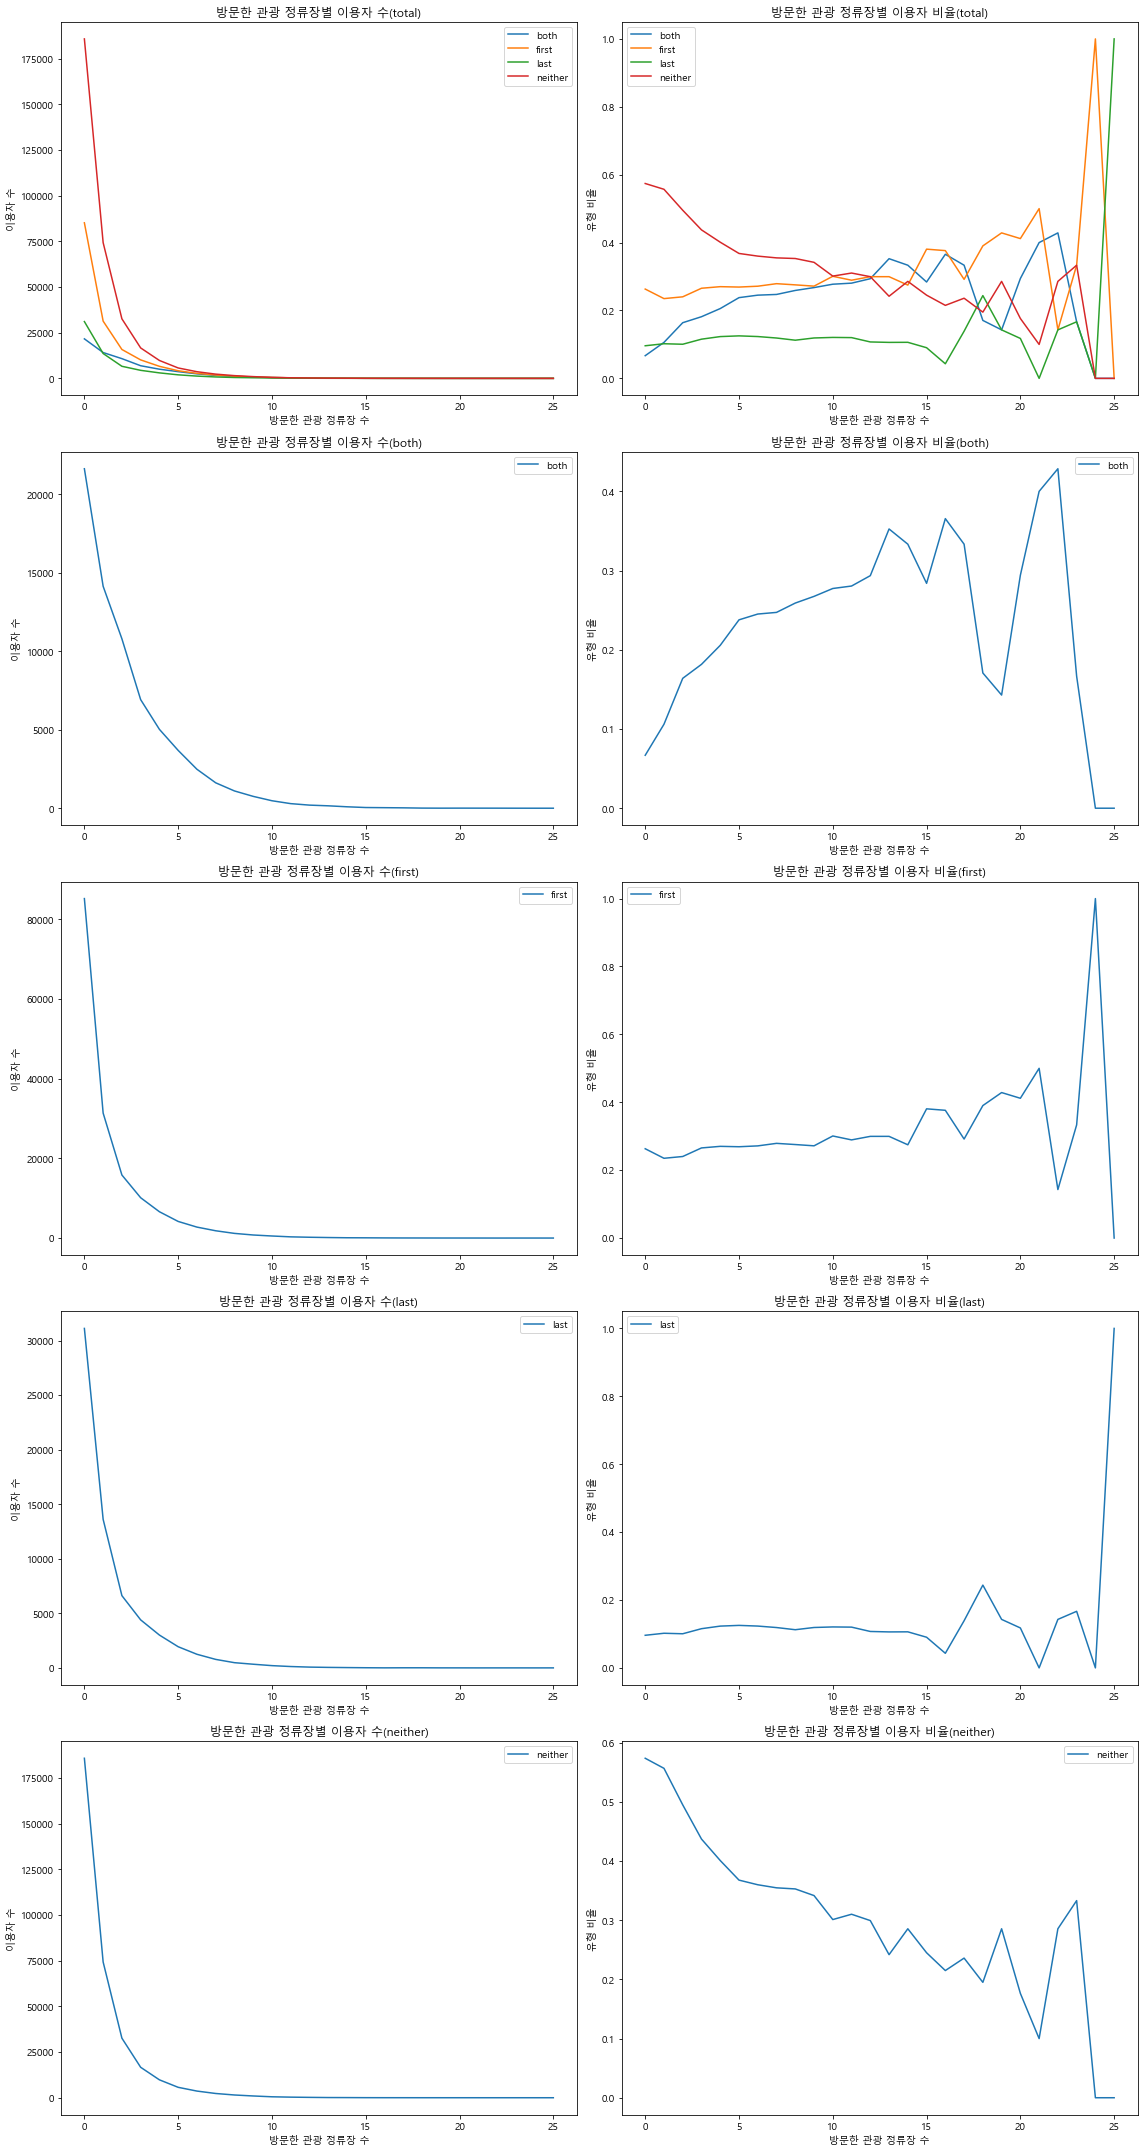

In [40]:
def draw_tour_visit_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []

    max_visit = int(user_df["tour_station_count"].max())
    for i in range(max_visit):
        sample_df = user_df[(i <=user_df["tour_station_count"]) & (user_df["tour_station_count"] <= i+1)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    # 그래프 그리기
    plt.figure(figsize=(16, 30))
    
    # 그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수") 
        
    # 그래프 - 유형별 그래프
    plt.subplot(5, 2, 2)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
        
    for idx, column in enumerate(columns):
        
        plt.subplot(5, 2, 2*(idx)+3)
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수")

        plt.subplot(5, 2, 2*(idx)+4)
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
    plt.tight_layout() 
    return plt

plt = draw_tour_visit_analysis_graph(user_df[user_df["period"]<15])
plt.show()

### 3-2) 알고리즘 검증 - case검증

In [ ]:
anz.draw_period_user_per_case(user_df)

### 3-3) 알고리즘 검증 - period검증

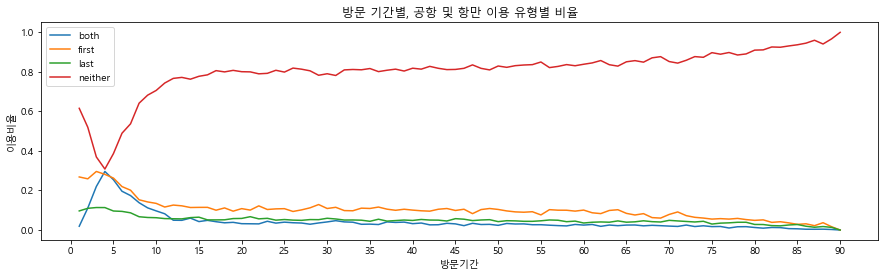

In [24]:
plt = anz.draw_period_analysis_graph(user_df)
plt.show()

### 3-4) 알고리즘 검증 - usage_ratio검증

   both 이용자수 = ( 90%미만:  22853명,  90%이상:  25399명)
  first 이용자수 = ( 90%미만:  40955명,  90%이상:  93119명)
   last 이용자수 = ( 90%미만:  18913명,  90%이상:  35299명)
neither 이용자수 = ( 90%미만: 300097명,  90%이상: 189557명)


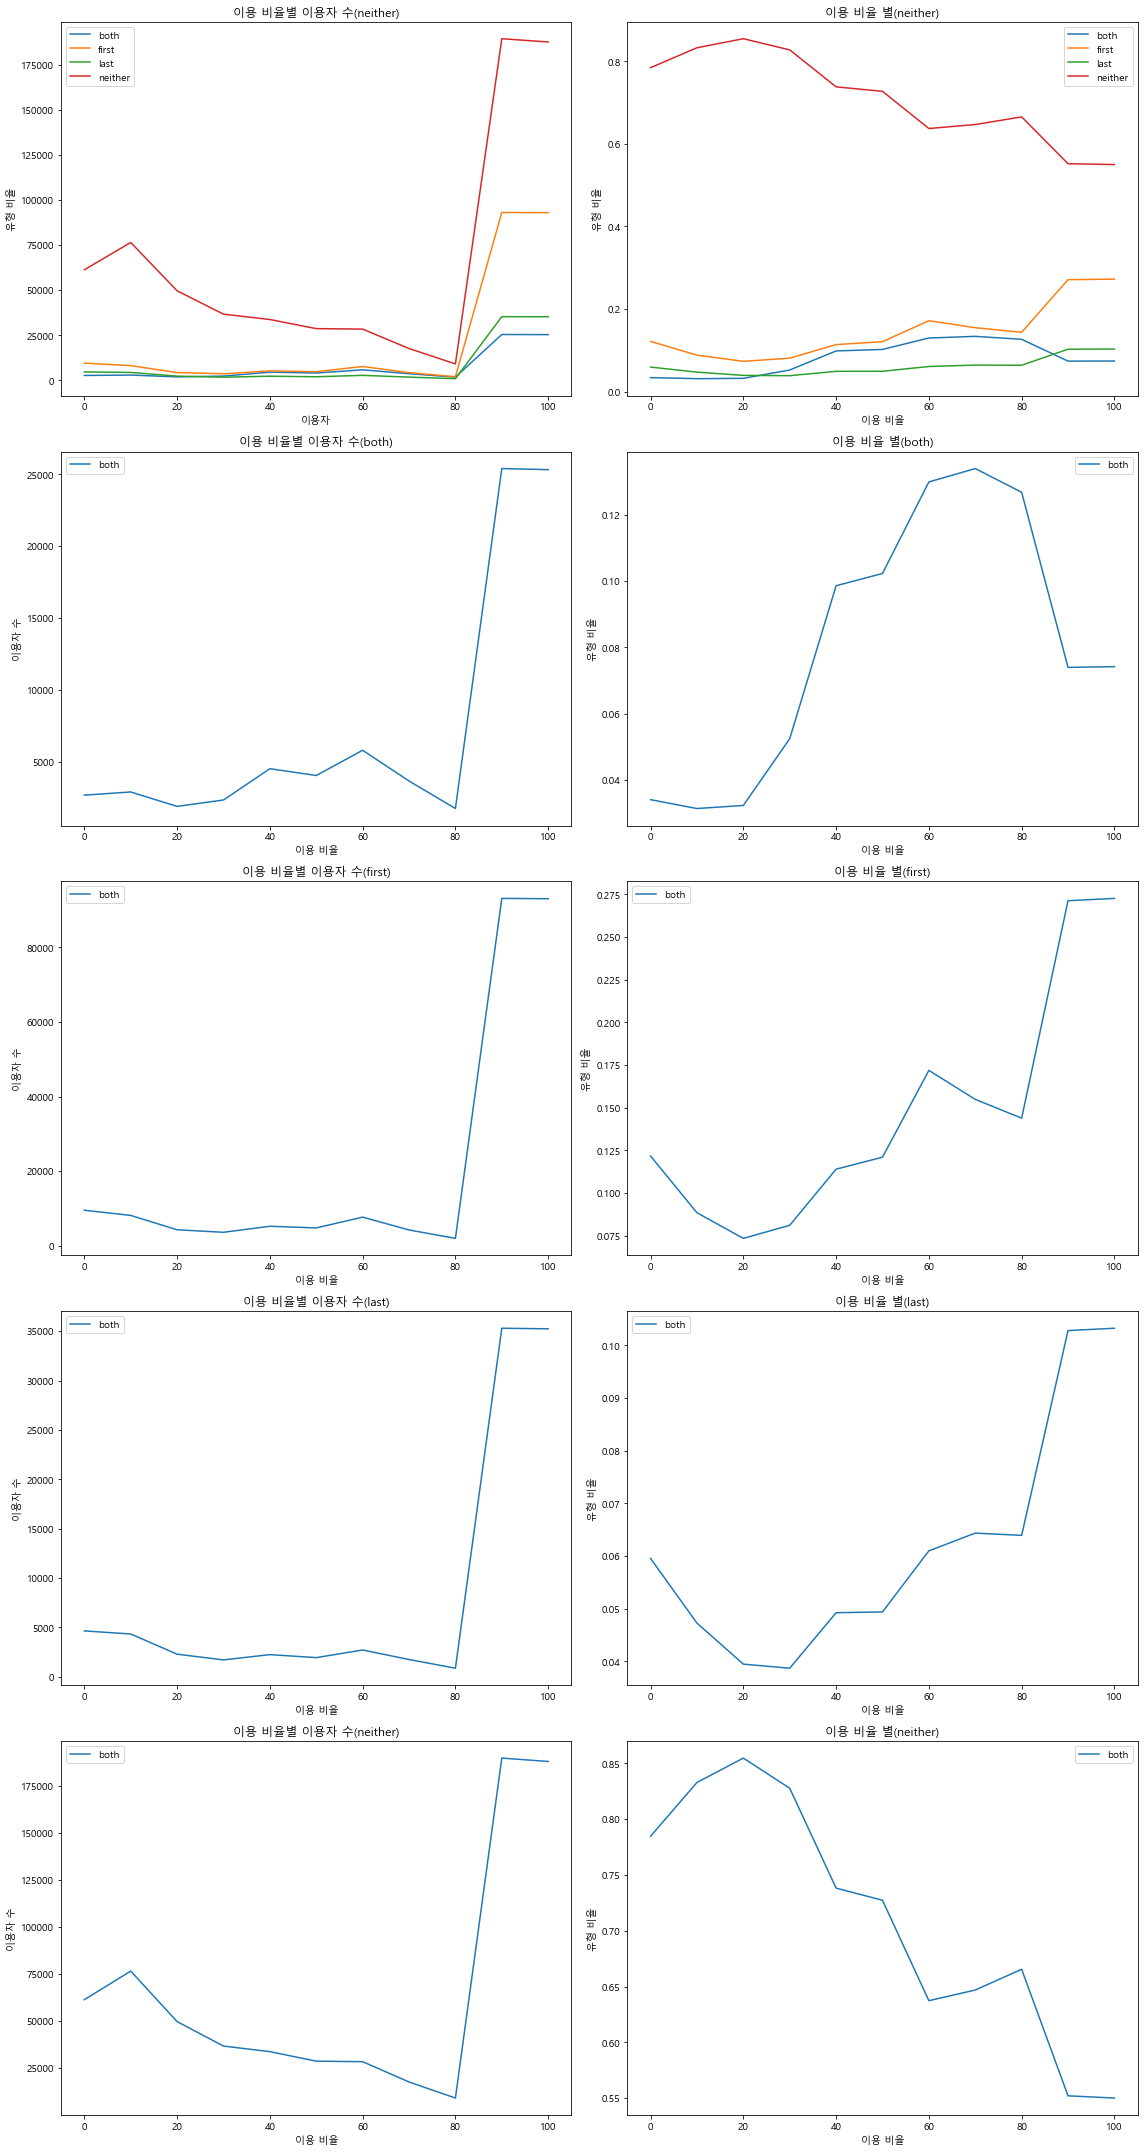

In [25]:
columns = ['both', 'first', 'last', 'neither']
boundary = 90
for column in columns:
    down = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] < boundary)])
    up = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] >= boundary)])
    print("%7s 이용자수 = (%3d%%미만: %6d명, %3d%%이상: %6d명)" % (column, boundary, down, boundary, up))
plt = anz.draw_usage_ratio_analysis_graph(user_df)
plt.show()

# 4. 결과 출력 

### 3-1) 이용자 출력

In [26]:
user_df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,True,False,False,False,2.0,1,True
1857,67b5aff10e2b979c1da4e125e0f47f405857a12883c44b...,2019-06-01,2019-06-02,2,2,9,100,airport,airport,True,False,False,False,2.0,1,True
2251,879541bcca73469aa71daf6ce5c22df2af19a6ae9f775f...,2019-06-01,2019-08-23,26,84,47,30,airport,airport,True,False,False,False,1.0,1,False
2278,af4d652be324b8553112236b71cacd2eaa940ba896ba30...,2019-06-01,2019-06-04,4,4,21,100,airport,airport,True,False,False,False,2.0,1,True
2483,571d1c70903db31339226b0cf80a6e3fcf605c8c4a4ade...,2019-06-01,2019-06-26,13,26,36,50,harbor,airport,True,False,False,False,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726186,c1b9568d0352a747567ffc1eeb6c773f6d7a5c40b0f25e...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,other,False,False,False,True,0.0,8,False


### 3-2) 정류장 출력

In [27]:
station_df

,station_id,station_name,station_longitude,station_latitude,station_address,tour_geton_usage,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage
3042,3271.0,제주시청(광양방면),126.53035,33.49892,제주특별자치도 제주시 이도이동 1938-1,1981.0,241714.0,1287.0,143835.0,388817.0
3041,3270.0,제주시청(아라방면),126.52977,33.49956,제주특별자치도 제주시 이도이동 1772-31,1491.0,193802.0,2160.0,160073.0,357526.0
334,357.0,한라병원,126.48508,33.48944,제주특별자치도 제주시 연동 2335-4,1275.0,137976.0,1000.0,86511.0,226762.0
335,358.0,한라병원,126.48600,33.48963,제주특별자치도 제주시 연동 251-66,1183.0,121324.0,1251.0,84701.0,208459.0
604,638.0,제주국제공항(구제주방면),126.49345,33.50661,제주특별자치도 제주시 용담이동 1462-1,10005.0,132228.0,5277.0,50603.0,198113.0
...,...,...,...,...,...,...,...,...,...,...
2505,2680.0,수산1리노인회관,126.88266,33.44670,제주특별자치도 서귀포시 성산읍 수산리 1199-1,0.0,1.0,0.0,0.0,1.0
1217,1309.0,이시돌상단지,126.33733,33.35975,제주특별자치도 제주시 한림읍 금악리 198-60,0.0,0.0,0.0,1.0,1.0
3459,4105.0,이스트힐스,126.63344,33.48146,제주특별자치도 제주시 회천동 229-3,0.0,1.0,0.0,0.0,1.0
1198,1285.0,하가삼거리,126.34830,33.45587,제주특별자치도 제주시 애월읍 하가리 1369-5,0.0,0.0,0.0,1.0,1.0


### 3-3) 방문기간 별 관광객 수 출력

<module 'matplotlib.pyplot' from 'C:\\Users\\hooni\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

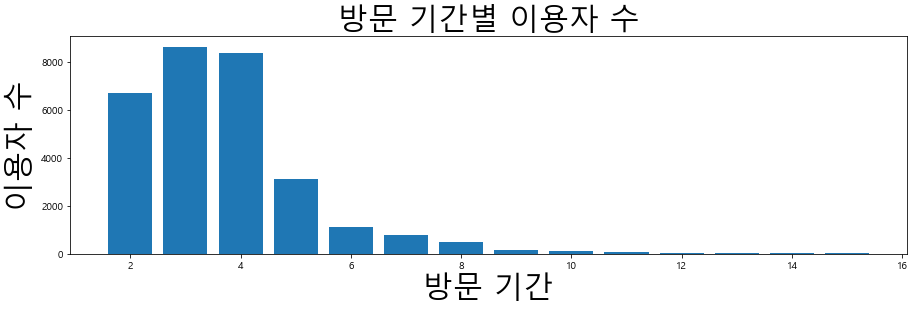

In [28]:
df = user_df[user_df["tourist"] == True]
anz.draw_period_user(plt, df)

### 3-1) both 관광객 출력

In [29]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-29-da876e3d4890>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1420849,20190610,2019-06-10 19:29:27,"제주국제공항(대정,화순,일주서로)",2019-06-10 19:59:03,애월환승정류장(애월리),1
1420848,20190610,2019-06-10 20:00:54,애월환승정류장(애월리),2019-06-10 20:01:40,한담동,1
1576756,20190611,2019-06-11 13:26:07,곽지해수욕장,2019-06-11 13:46:56,옹포사거리,1
1576755,20190611,2019-06-11 17:12:43,협재해수욕장,2019-06-11 17:39:23,한담동,1
1602029,20190612,2019-06-12 11:36:25,한담동,2019-06-12 12:35:08,서문시장,1
1602028,20190612,2019-06-12 14:40:17,관덕정,2019-06-12 15:00:48,이호테우해수욕장,1
1602031,20190612,2019-06-12 15:50:21,오광로입구,2019-06-12 16:23:59,곽지해수욕장,1
1602030,20190612,2019-06-12 17:20:05,곽지해수욕장,2019-06-12 18:35:13,서문시장,1
12724,20190613,2019-06-13 07:00:53,관덕정,2019-06-13 07:06:03,제주국제공항(신제주방면),1


### 3-2) first 관광객 출력

In [30]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-30-24ff40b1a0e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1523314,20190611,2019-06-11 21:29:42,제주국제공항(구제주방면),2019-06-11 21:41:58,남서광마을입구,1
1646584,20190612,2019-06-12 10:02:53,제주국제공항(구제주방면),2019-06-12 10:14:04,관덕정,1
1646585,20190612,2019-06-12 15:24:51,한담동,2019-06-12 16:48:31,산방산,1
1646583,20190612,2019-06-12 17:50:42,산방산,2019-06-12 18:36:58,진부동,1
56042,20190613,2019-06-13 10:37:18,동문로터리(동문시장),2019-06-13 10:43:20,우당도서관입구,1
56040,20190613,2019-06-13 10:54:56,6호광장,2019-06-13 11:54:45,성산항,1
56044,20190613,2019-06-13 16:24:18,성산항,2019-06-13 16:32:49,성산일출봉입구,1
56043,20190613,2019-06-13 19:13:16,성산일출봉입구,2019-06-13 19:43:19,월정리,1
56041,20190613,2019-06-13 20:47:35,월정리,2019-06-13 21:38:59,제일교동문시장입구,1


### 3-3) last 관광객 출력

In [31]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 100)

<ipython-input-31-0538c16b190b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1384136,20190610,2019-06-10 19:28:46,중문관광단지,2019-06-10 20:07:08,솔동산입구,4
1548287,20190611,2019-06-11 09:21:52,동문로터리,2019-06-11 09:54:27,성판악,5
1548288,20190611,2019-06-11 17:38:33,성판악,2019-06-11 18:07:53,동문로터리,1
1741453,20190612,2019-06-12 10:01:54,서귀포항,NaT,NaN,1
56116,20190613,2019-06-13 08:46:31,은남동,2019-06-13 08:58:51,제주버스터미널,5
56113,20190613,2019-06-13 09:20:01,제주버스터미널,2019-06-13 10:39:30,성산항,5
56114,20190613,2019-06-13 17:02:34,성산항,2019-06-13 18:26:19,제주버스터미널,5
56115,20190613,2019-06-13 18:32:56,제주버스터미널,2019-06-13 18:46:49,은남동,5
273518,20190614,2019-06-14 11:55:27,메종글래드제주,NaT,NaN,1
273517,20190614,2019-06-14 11:55:41,메종글래드제주,2019-06-14 12:07:02,제주국제공항(구제주방면),4


### 3-4) neither 관광객 출력

In [32]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 150)

<ipython-input-32-9fc015b0b5a4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
675738,20190605,2019-06-05 18:53:45,서문시장,2019-06-05 19:04:47,일도2동주민센터,1
675739,20190605,2019-06-05 20:41:05,제주여자상업고등학교,2019-06-05 20:55:47,화물청사입구,1
832209,20190606,2019-06-06 12:04:01,시외버스출발지(가상정류소),2019-06-06 13:50:32,성산일출봉입구,1
832213,20190606,2019-06-06 14:46:08,성산일출봉입구,2019-06-06 15:01:51,신양리입구,1
832215,20190606,2019-06-06 16:34:15,섭지코지,2019-06-06 16:39:47,고성리제주은행,1
832210,20190606,2019-06-06 16:42:21,고성리제주은행,2019-06-06 17:21:47,만장굴입구,1
832214,20190606,2019-06-06 17:45:05,만장굴입구,2019-06-06 17:48:38,행원목장,1
832211,20190606,2019-06-06 19:07:53,김녕미로공원,2019-06-06 19:11:37,만장굴입구,1
832216,20190606,2019-06-06 19:24:08,만장굴입구,2019-06-06 20:21:08,광양사거리,1
832212,20190606,2019-06-06 22:59:44,광양사거리,2019-06-06 23:04:26,제주버스터미널(종점),1
